## Домашнее задание №3 (курс "Практикум по программированию на языке Python")

### Выполнил: <font color='red'>Никитин Артем Анатольевич, МФТИ, ФПМИ</font>

### Тема: Основы работы с искусственными нейронными сетями

#### Преподаватель: Мурат Апишев (mel-lain@yandex.ru)

**Выдана**:   22 марта 2025

**Дедлайн**:   21:00 5 апреля 2025

**Среда выполнения**: Jupyter Notebook (Python 3.10+)

#### Правила:

Результат выполнения задания - Jupyter Notebook с кодом и подробными ответами в случае теоретических вопросов. __Максимальное число баллов за задание - 30__.

Все ячейки должны быть "выполненными", при этом результат должен воспроизводиться при проверке (на Python 3.10). Если какой-то код не был запущен или отрабатывает с ошибками, то пункт не засчитывается. Задание, сданное после дедлайна, _не принимается_. Можно отправить недоделанное задание, выполненные пункты будут оценены.

Готовое задание отправляется на почту mel-lain@yandex.ru.

Задание выполняется самостоятельно. Если какие-то студенты будут уличены в списывании, все они автоматически получат за эту работу 0 баллов. Если вы нашли в Интернете какой-то специфичный код, который собираетесь заимствовать, обязательно укажите это в задании - наверняка вы не единственный, кто найдёт и использует эту информацию. <font color='blue'>Для решения задач этой лабораторной работы запрещается использовать любые приложения/API для генерации кода на основе LLM.</font>

__Удалять фрагменты формулировок заданий запрещается.__

#### Постановка задачи:

- В данной работе нужно решить задачи векторизации и классификации текстов несколькими способами с помощью нейросетевых моделей и сравнить между собой.
- Даже если это не указано явно в требованиях, код должен быть по возможности неизбыточным, работать с разумной сложностью и объёмом потребляемой памяти, проверяющие могут снизить балл за задание, выполненное без учёта этого требования.
- Результирующий код должен быть читаемым, с единой системой отступов и адеквантными названиями переменных, проверяющие могут снизить балл за задание, выполненное без учёта этого требования.
- Везде, где это требуется, должны быть отрисованы необходимые графики и даны комментарии и выводы.
- Для выполнения задания потребуется машина с GPU, если его нет на своем ноутбуке/ПК, можно использовать Google Colab
- __Любая ячейка кода в задании (кроме обучения базовой лог-регрессии) при реализации в векторном виде и запуске на поддерживающей этот код GPU не должна выполняться более получаса, большая часть кода должна выполняться быстрее__

Для выполнения задания нужно загрузить набор данных для задачи multi-label классификации текстов EURLex (только английскую часть) следующим кодом:

In [1]:
from datasets import load_dataset

dataset = load_dataset('multi_eurlex', 'en')

__Задание 1 (5 баллов):__ Самый простой способ выучить модель классификации - использовать лог-регрессию на сжатых плотных векторах документов. Для этого нужно выполнить ряд подзадач.

Преобразовать данные в векторный вид с помощью `CountVectorizer` и `TruncatedSVD`:

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD


def vectorize(max_features, n_components):
    vect = CountVectorizer(max_features=max_features, lowercase=True, stop_words="english", min_df=2)
    x_train_bow = vect.fit_transform(dataset['train']['text'])
    x_valid_bow = vect.transform(dataset['validation']['text'])
    x_test_bow = vect.transform(dataset['test']['text'])

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    x_train = svd.fit_transform(x_train_bow)
    x_valid = svd.transform(x_valid_bow)
    x_test = svd.transform(x_test_bow)
    return x_train, x_valid, x_test


X_train, X_valid, X_test = vectorize(100_000, 300)
print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Train: (55000, 300) Valid: (5000, 300) Test: (5000, 300)


Конвертировать метки классов в вид бинарной матрицы с размером "число объектов" на "число классов":

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(dataset["train"]["labels"])
y_valid = mlb.transform(dataset["validation"]["labels"])
y_test = mlb.transform(dataset["test"]["labels"])
print("Y‑shape:", y_train.shape, y_valid.shape, y_test.shape)

Y‑shape: (55000, 21) (5000, 21) (5000, 21)


Обучить мета-модель на основе лог-регрессии с помощью `MultiOutputClassifier`:

In [4]:
print("See code below!")

See code below!


Описать функцию подбора оптимальных порогов бинаризации для каждого класса и подобрать их для модели на валидационной выборке:

In [5]:
import numpy as np
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score


def calculate_best_thresholds(model, x_val, y_val, average: str = 'macro', step: float = 0.02):
    probas = np.column_stack([p[:, 1] for p in model.predict_proba(x_val)])

    thresholds = np.arange(0.0, 1.0 + 1e-9, step)

    mask = probas[:, :, None] >= thresholds[None, None, :]
    y_broad = y_val[:, :, None].astype(bool)

    res = None
    if average == 'macro':
        tp = np.sum(mask & y_broad, axis=0)
        fp = np.sum(mask & (~y_broad), axis=0)
        fn = np.sum((~mask) & y_broad, axis=0)

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        best_idx = np.argmax(f1, axis=1)
        res = thresholds[best_idx]

    elif average == 'micro':
        tp = np.sum(mask & y_broad, axis=(0, 1))
        fp = np.sum(mask & (~y_broad), axis=(0, 1))
        fn = np.sum((~mask) & y_broad, axis=(0, 1))

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        best_idx = np.argmax(f1)
        best_t = thresholds[best_idx]
        res = np.full(y_val.shape[1], best_t, dtype=float)
    return res


def train_and_eval(x_train, x_valid, x_test):
    base = LogisticRegression(solver="saga", penalty="l2", max_iter=1200, tol=1e-3, n_jobs=-1, class_weight="balanced")
    clf = MultiOutputClassifier(base, n_jobs=-1).fit(x_train, y_train)

    best_thr = calculate_best_thresholds(clf, x_valid, y_valid, step=0.05)

    prob_test = np.column_stack([p[:, 1] for p in clf.predict_proba(x_test)])
    y_pr = (prob_test >= best_thr)

    f1_mic = f1_score(y_test, y_pr, average="micro")
    f1_mac = f1_score(y_test, y_pr, average="macro")

    return f1_mic, f1_mac

Описать код применения модели и порогов к выходным вероятностям для получения значений F1-меры с micro и macro усреднениями и вычислить их на тестовой выборке. Для получения максимального балла код этого подзадания должен быть написан в векторном виде с помощью NumPy, без циклов:

In [6]:
f1_micro, f1_macro = train_and_eval(X_train, X_valid, X_test)
print(f"micro‑F1 = {f1_micro:.4f}, macro‑F1 = {f1_macro:.4f}")

micro‑F1 = 0.6511, macro‑F1 = 0.5385


Провести набор запусков с различными комбинациями размера словаря `CountVectorizer` и числа компонент в `TruncatedSVD` и оценить их влияние на качество на текстовой выборке

- попробовать нужно как минимум 3 существенно различных значения для каждого параметра
- результаты должны быть представлены наглядно в виде таблиц и сделанных на их основе выводов

In [7]:
import pandas as pd
from itertools import product

grid_max_features = [50_000, 100_000, 200_000]
grid_n_components = [100, 300, 600]

results = []
for max_feat, n_comp in tqdm(list(product(grid_max_features, grid_n_components)), desc='Experiments'):
    X_train, X_valid, X_test = vectorize(max_feat, n_comp)

    f1_micro, f1_macro = train_and_eval(X_train, X_valid, X_test)

    results.append(dict(max_features=max_feat,
                        n_components=n_comp,
                        f1_macro=f1_macro,
                        f1_micro=f1_micro))

df = pd.DataFrame(results).sort_values(['max_features', 'n_components']).reset_index(drop=True)
display(df.reset_index(drop=True).style.hide(axis="index"))

Experiments:   0%|          | 0/9 [00:00<?, ?it/s]

max_features,n_components,f1_macro,f1_micro
50000,100,0.496997,0.612657
50000,300,0.534909,0.644042
50000,600,0.550335,0.658376
100000,100,0.500420,0.617286
100000,300,0.538512,0.650924
100000,600,0.549885,0.667271
200000,100,0.500443,0.617300
200000,300,0.538554,0.650973
200000,600,0.548049,0.666332


Вывод: лучший результат получается при максимальном `n_components`, от `max_features` результат практически не хависит.

__Задание 2 (5 баллов):__ Заменить метод векторизации документов для модели выше на BERT.

Описать код класса BERTVectorizer, который должен уметь обрабатывать данные в батчевом режиме на заданном устройстве. Должно быть предусмотрено 2 режима формирования векторов документов - на основе CLS-токена и на основе усреднения всех выходных векторов (тут нужно использовать поле `attention_mask` и игнорировать векторы токенов паддинга, для которых в маске записан 0):

In [8]:
import torch
from transformers import AutoTokenizer, AutoModel


class BERTVectorizer:
    def __init__(self, model_name: str, batch_size: int = 100, device: str = "cuda:0"):
        self.batch_size = batch_size
        self.device = torch.device(device)

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()

    def __call__(self, texts, averaging: str = "cls"):
        embeddings = []
        for start in range(0, len(texts), self.batch_size):
            batch_texts = texts[start: start + self.batch_size]
            emb = self._vectorize_batch(batch_texts, averaging)
            embeddings.append(emb)

        return np.vstack(embeddings)

    def _vectorize_batch(self, texts, averaging: str):
        enc = self.tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt",
        ).to(self.device)

        with torch.no_grad():
            last_hidden = self.model(**enc).last_hidden_state

        batch_embeddings = None
        if averaging == "cls":
            batch_embeddings = last_hidden[:, 0, :]
        elif averaging == "mean":
            mask = enc["attention_mask"].unsqueeze(-1)
            summed = (last_hidden * mask).sum(dim=1)
            counts = mask.sum(dim=1).clamp(min=1)
            batch_embeddings = summed / counts
        return batch_embeddings.cpu().numpy().astype(np.float32)

Использовать его для векторизации данных с помощью модели `cointegrated/rubert-tiny2`:

In [9]:
def vectorize_smart(vectorizer, averaging):
    x_train = vectorizer(dataset["train"]["text"], averaging=averaging)
    x_valid = vectorizer(dataset["validation"]["text"], averaging=averaging)
    x_test = vectorizer(dataset["test"]["text"], averaging=averaging)
    return x_train, x_valid, x_test


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bert_vec = BERTVectorizer(model_name="cointegrated/rubert-tiny2", batch_size=128, device=DEVICE)
X_train, X_valid, X_test = vectorize_smart(bert_vec, "cls")
print(X_train.shape, X_valid.shape, X_test.shape)

(55000, 312) (5000, 312) (5000, 312)


Описать код сохранения/загрузки векторов с диска:

In [10]:
import os

DIR = "embeddings"
os.makedirs(DIR, exist_ok=True)


def vec_save(x_train, x_valid, x_test):
    np.save(os.path.join(DIR, "X_train_rubert_cls.npy"), x_train)
    np.save(os.path.join(DIR, "X_valid_rubert_cls.npy"), x_valid)
    np.save(os.path.join(DIR, "X_test_rubert_cls.npy"), x_test)


def vec_load():
    x_train = np.load(os.path.join(DIR, "X_train_rubert_cls.npy"))
    x_valid = np.load(os.path.join(DIR, "X_valid_rubert_cls.npy"))
    x_test = np.load(os.path.join(DIR, "X_test_rubert_cls.npy"))
    return x_train, x_valid, x_test


vec_save(X_train, X_valid, X_test)
X_train, X_valid, X_test = vec_load()
print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Train: (55000, 312) Valid: (5000, 312) Test: (5000, 312)


Повторить обучение модели и замер качества из п.1 на новых векторах:

In [11]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
f1_micro, f1_macro = train_and_eval(X_train, X_valid, X_test)
print(f"micro‑F1 = {f1_micro:.4f}, macro‑F1 = {f1_macro:.4f}")

micro‑F1 = 0.6580, macro‑F1 = 0.5474


Попробовать заменить векторизатор на более крупный и качественный (например, `intfloat/multilingual-e5-base` или `sentence-transformers/paraphrase-xlm-r-multilingual-v1`) и повторить обучение, сделать выводы о качестве:

In [12]:
vect_e5 = BERTVectorizer(model_name="intfloat/multilingual-e5-base", batch_size=64, device="cuda:0")
X_train_e5, X_valid_e5, X_test_e5 = vectorize_smart(vect_e5, "mean")
print(X_train.shape, X_valid.shape, X_test.shape)

(55000, 312) (5000, 312) (5000, 312)


In [13]:
f1_e5_micro, f1_e5_macro = train_and_eval(X_train_e5, X_valid_e5, X_test_e5)
print(f"E5‑base    micro-F1: {f1_e5_micro:.4f}, macro-F1: {f1_e5_macro:.4f}")

E5‑base    micro-F1: 0.7165, macro-F1: 0.6119


__Задание 3 (5 баллов):__ Реализовать модель, похожую на реализованную в п.1, на PyTorch.

Описать класс модели с одним линейным слоем, в качестве активации на выходе опробовать сигмоиду:

In [14]:
import torch.nn as nn


class Model(nn.Module):
    def __init__(self, embedding_dim: int, num_labels: int):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_labels)
        self.activation = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = self.linear(x)
        probs = self.activation(logits)
        return probs

Получить с помощью кода из п.1 векторные представления данных:

In [15]:
X_train, X_valid, X_test = vectorize(100_000, 300)
print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)

Train: (55000, 300) Valid: (5000, 300) Test: (5000, 300)


Описать код класса датасета, объявить датасеты и загрузчики данных с подходящими размерами батчей:

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = TextDataset(X_train, y_train)
valid_dataset = TextDataset(X_valid, y_valid)
test_dataset = TextDataset(X_test, y_test)

train_batch_size = 128
eval_batch_size = 256

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

Создать модель, оптимизатор и функцией потерь binary cross-entropy:

In [17]:
import torch.optim as optim

model = Model(embedding_dim=X_train.shape[1], num_labels=y_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCELoss()

- Описать цикл обучения, на каждом шаге считать лосс на валидационном датасете
- Раз в несколько шагов подбирать на валидации оптимальные пороги бинаризации и делать на нём же замер F1-меры с micro/macro усреднениями
- Запустить обучение с необходимым числом эпох с замером времени выполнения эпохи
- Для лучшей модели в конце обучения повторно подобрать пороги на валидации и произвести итоговый замер на тестовых данных
- Вывести графики убывания лосса на обучении и валидации и значений метрик

Epoch 0 | Time 1.1207s | Train Loss 0.3578 | Valid Loss 0.3189 | Val F1-micro 0.6691 | Val F1-macro 0.5445
Epoch 1 | Time 1.3540s | Train Loss 0.2518 | Valid Loss 0.3031 | Val F1-micro 0.7060 | Val F1-macro 0.5746
Epoch 2 | Time 1.2946s | Train Loss 0.2419 | Valid Loss 0.3043 | Val F1-micro 0.7192 | Val F1-macro 0.5837
Epoch 3 | Time 1.2282s | Train Loss 0.2388 | Valid Loss 0.3034 | Val F1-micro 0.7202 | Val F1-macro 0.5881
Epoch 4 | Time 1.1292s | Train Loss 0.2376 | Valid Loss 0.3126 | Val F1-micro 0.7253 | Val F1-macro 0.5910
Epoch 5 | Time 0.8682s | Train Loss 0.2374 | Valid Loss 0.3086 | Val F1-micro 0.7291 | Val F1-macro 0.5980
Epoch 6 | Time 0.7935s | Train Loss 0.2367 | Valid Loss 0.3159 | Val F1-micro 0.7318 | Val F1-macro 0.5965
Epoch 7 | Time 0.8101s | Train Loss 0.2366 | Valid Loss 0.3132 | Val F1-micro 0.7359 | Val F1-macro 0.6028
Epoch 8 | Time 0.7516s | Train Loss 0.2362 | Valid Loss 0.3129 | Val F1-micro 0.7366 | Val F1-macro 0.6046
Epoch 9 | Time 0.7430s | Train Loss 0

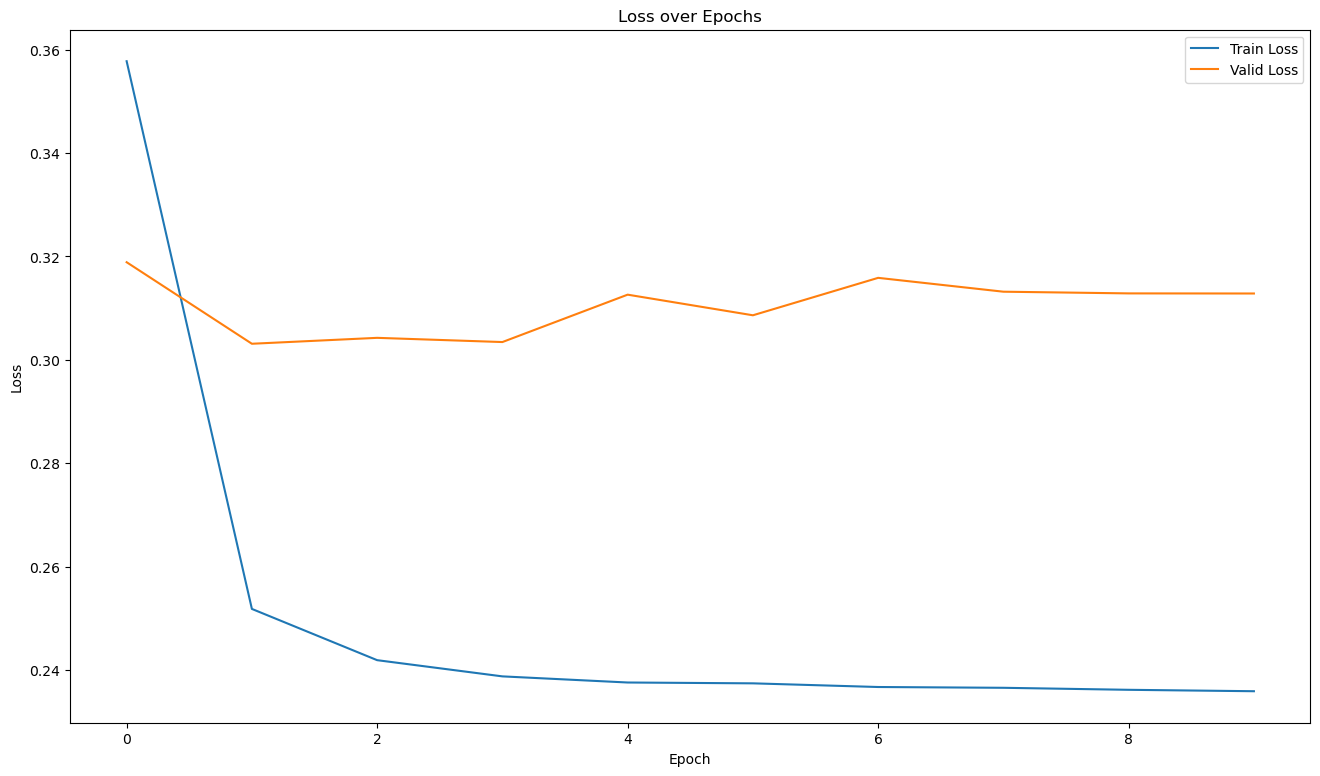

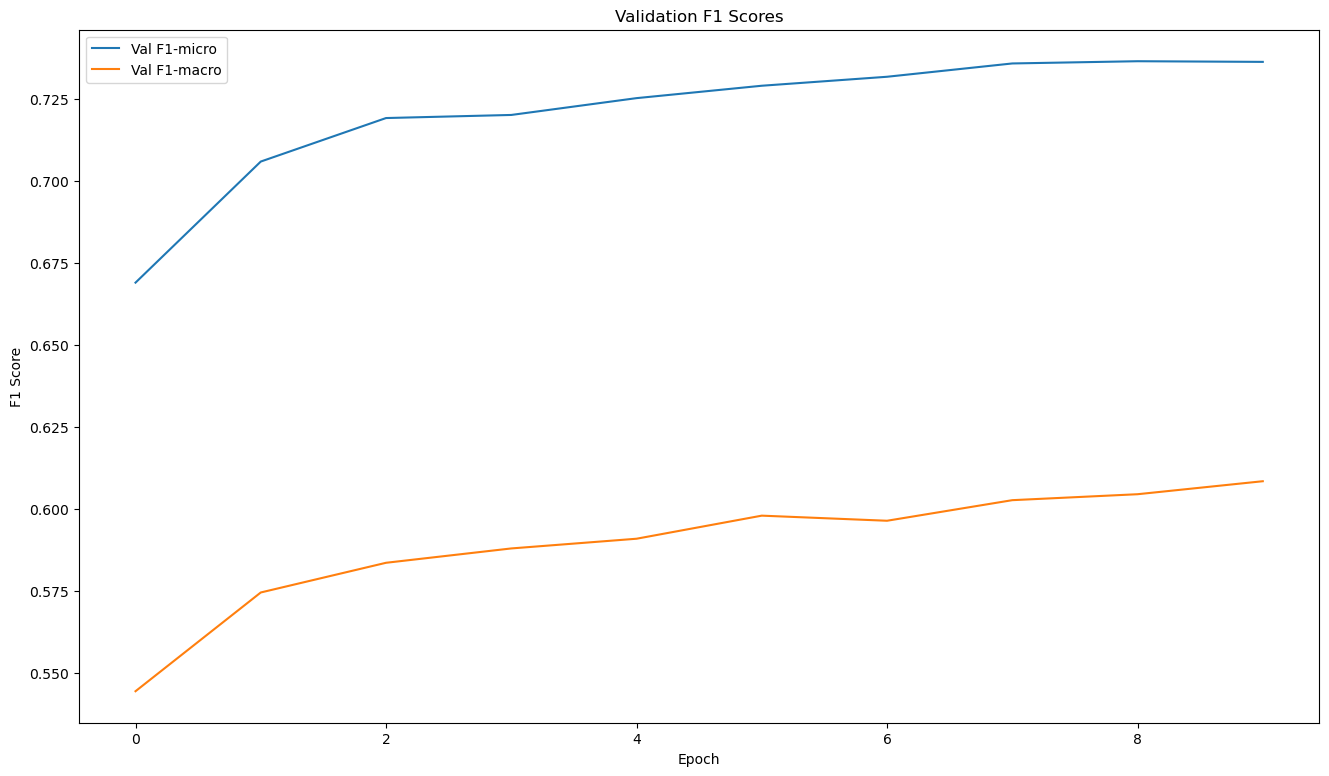

In [18]:
import time
import matplotlib.pyplot as plt


class TorchModelWrapper:
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def predict_proba(self, X):
        self.model.eval()
        X_t = torch.from_numpy(X).float().to(self.device)
        with torch.no_grad():
            probs = self.model(X_t).cpu().numpy()
        return [np.stack([1 - probs[:, j], probs[:, j]], axis=1)
                for j in range(probs.shape[1])]


num_epochs = 10
wrapper = TorchModelWrapper(model, DEVICE)

train_loss_list, valid_loss_list = [], []
val_f1_micro_list, val_f1_macro_list = [], []
best_f1_macro = -1.0
best_model_state = None
best_thresholds = None

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    model.eval()
    total_valid_loss = 0.0
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            total_valid_loss += criterion(preds, yb).item()
    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_loss_list.append(avg_valid_loss)

    best_thresh = calculate_best_thresholds(wrapper, X_valid, y_valid,
                                            average='macro', step=0.02)
    val_probas = np.column_stack([p[:, 1] for p in wrapper.predict_proba(X_valid)])
    val_preds = val_probas >= best_thresh
    f1_mic = f1_score(y_valid, val_preds, average='micro')
    f1_mac = f1_score(y_valid, val_preds, average='macro')
    val_f1_micro_list.append(f1_mic)
    val_f1_macro_list.append(f1_mac)

    if f1_mac > best_f1_macro:
        best_f1_macro = f1_mac
        best_model_state = model.state_dict()
        best_thresholds = best_thresh.copy()

    print(
        f"Epoch {epoch} | "
        f"Time {time.time() - start_time:.4f}s | "
        f"Train Loss {avg_train_loss:.4f} | Valid Loss {avg_valid_loss:.4f} | "
        f"Val F1-micro {f1_mic:.4f} | Val F1-macro {f1_mac:.4f}"
    )

model.load_state_dict(best_model_state)
model.eval()
test_probas = np.column_stack([p[:, 1] for p in wrapper.predict_proba(X_test)])
test_preds = test_probas >= best_thresholds
test_f1_mic = f1_score(y_test, test_preds, average='micro')
test_f1_mac = f1_score(y_test, test_preds, average='macro')
print(f"Best Test F1-micro: {test_f1_mic:.4f}, F1-macro: {test_f1_mac:.4f}")

plt.figure(figsize=(16, 9))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.figure(figsize=(16, 9))
plt.plot(val_f1_micro_list, label='Val F1-micro')
plt.plot(val_f1_macro_list, label='Val F1-macro')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Validation F1 Scores')

plt.show()


Заменить активацию на Softmax, а функцию потерь на кросс-энтропию, переобучить модель при тех же условиях, измерить качество и сделать выводы о причинах его изменения:

Epoch 0 | Time 0.8708s | Train Loss 1.6529 | Valid Loss 1.5248 | Val F1-micro 0.6366 | Val F1-macro 0.2772
Epoch 1 | Time 0.7449s | Train Loss 1.2077 | Valid Loss 1.4846 | Val F1-micro 0.6420 | Val F1-macro 0.2980
Epoch 2 | Time 0.7222s | Train Loss 1.1526 | Valid Loss 1.4636 | Val F1-micro 0.6442 | Val F1-macro 0.2987
Epoch 3 | Time 0.7400s | Train Loss 1.1303 | Valid Loss 1.4552 | Val F1-micro 0.6474 | Val F1-macro 0.3128
Epoch 4 | Time 0.7273s | Train Loss 1.1060 | Valid Loss 1.4974 | Val F1-micro 0.6508 | Val F1-macro 0.3059
Epoch 5 | Time 0.7227s | Train Loss 1.0988 | Valid Loss 1.4805 | Val F1-micro 0.6570 | Val F1-macro 0.3032
Epoch 6 | Time 0.7208s | Train Loss 1.0885 | Valid Loss 1.4877 | Val F1-micro 0.6510 | Val F1-macro 0.3176
Epoch 7 | Time 0.7332s | Train Loss 1.0801 | Valid Loss 1.4771 | Val F1-micro 0.6542 | Val F1-macro 0.3140
Epoch 8 | Time 0.7515s | Train Loss 1.0795 | Valid Loss 1.4682 | Val F1-micro 0.6636 | Val F1-macro 0.3239
Epoch 9 | Time 0.8016s | Train Loss 1

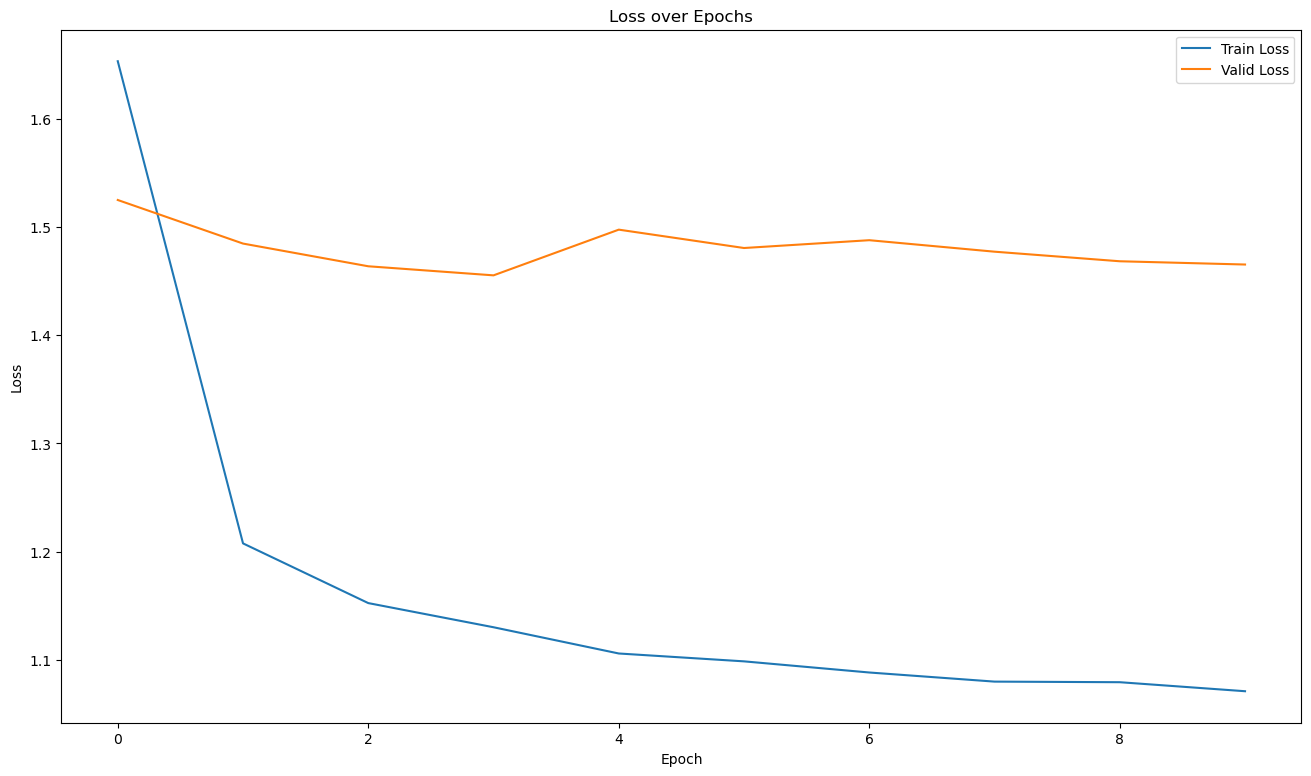

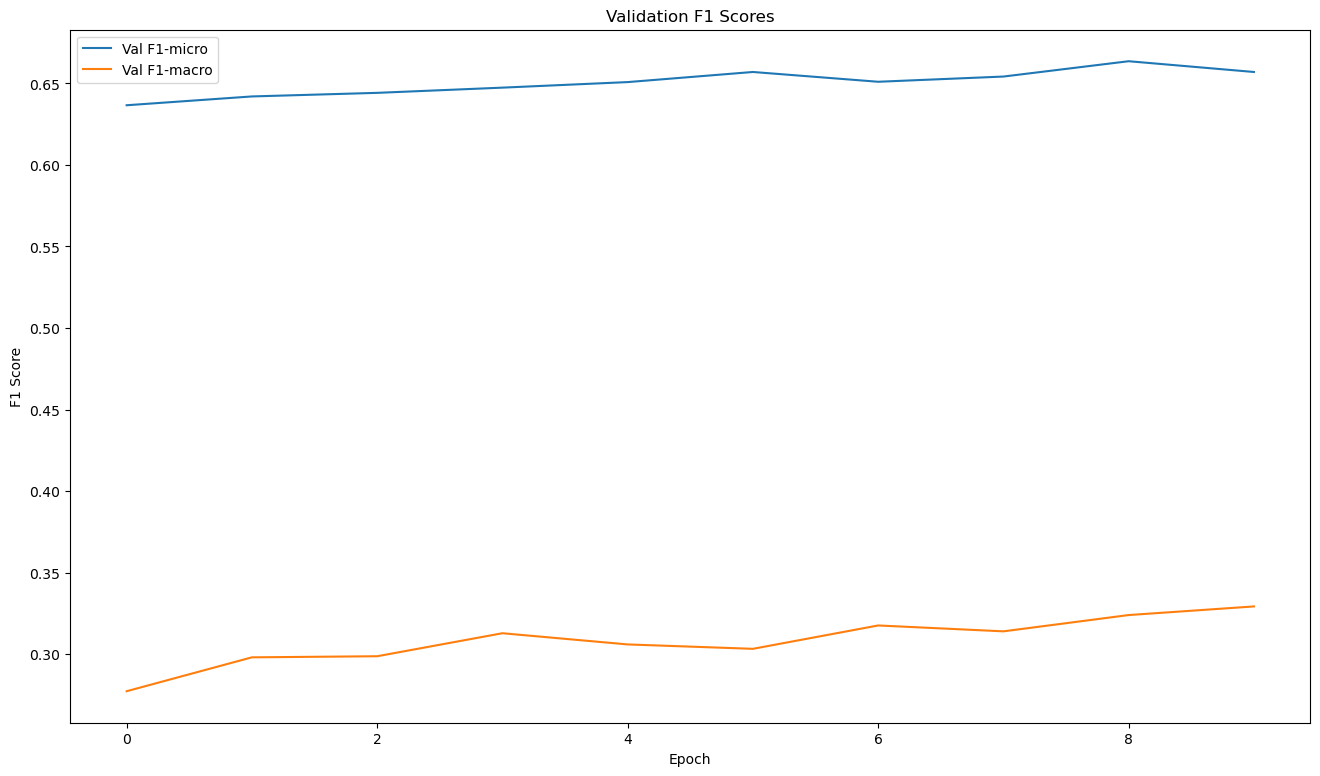

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim


class ModelCE(nn.Module):
    def __init__(self, embedding_dim: int, num_labels: int):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_labels)
        self.activation = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        logits = self.linear(x)
        probs = self.activation(logits)
        return logits, probs


y_train_idx = y_train.argmax(axis=1)
y_valid_idx = y_valid.argmax(axis=1)
y_test_idx = y_test.argmax(axis=1)


class SingleLabelDataset(torch.utils.data.Dataset):
    def __init__(self, X, y_idx):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y_idx).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_ds_ce = SingleLabelDataset(X_train, y_train_idx)
valid_ds_ce = SingleLabelDataset(X_valid, y_valid_idx)
test_ds_ce = SingleLabelDataset(X_test, y_test_idx)

train_loader_ce = DataLoader(train_ds_ce, batch_size=train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_loader_ce = DataLoader(valid_ds_ce, batch_size=eval_batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader_ce = DataLoader(test_ds_ce, batch_size=eval_batch_size, shuffle=False, num_workers=2, pin_memory=True)

model_ce = ModelCE(embedding_dim=X_train.shape[1], num_labels=y_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(model_ce.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

train_loss_list, valid_loss_list = [], []
val_f1_micro_list, val_f1_macro_list = [], []
best_f1_macro = -1.0
best_model_state = None

for epoch in range(num_epochs):
    start_time = time.time()

    model_ce.train()
    total_tr = 0.0
    for xb, yb in train_loader_ce:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits, _ = model_ce(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_tr += loss.item()
    avg_tr = total_tr / len(train_loader_ce)
    train_loss_list.append(avg_tr)

    model_ce.eval()
    total_val = 0.0
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in valid_loader_ce:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits, probs = model_ce(xb)
            total_val += criterion(logits, yb).item()
            preds = probs.cpu().numpy().argmax(axis=1)
            all_preds.append(preds)
            all_true.append(yb.cpu().numpy())

    avg_val = total_val / len(valid_loader_ce)
    valid_loss_list.append(avg_val)
    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)
    f1_mic = f1_score(all_true, all_preds, average='micro')
    f1_mac = f1_score(all_true, all_preds, average='macro')
    val_f1_micro_list.append(f1_mic)
    val_f1_macro_list.append(f1_mac)

    if f1_mac > best_f1_macro:
        best_f1_macro = f1_mac
        best_model_state = model_ce.state_dict()

    print(
        f"Epoch {epoch} | Time {time.time() - start_time:.4f}s | "
        f"Train Loss {avg_tr:.4f} | Valid Loss {avg_val:.4f} | "
        f"Val F1-micro {f1_mic:.4f} | Val F1-macro {f1_mac:.4f}"
    )

model_ce.load_state_dict(best_model_state)
model_ce.eval()
test_preds_list, test_true_list = [], []
with torch.no_grad():
    for xb, yb in test_loader_ce:
        xb = xb.to(DEVICE)
        _, probs = model_ce(xb)
        test_preds_list.append(probs.cpu().numpy().argmax(axis=1))
        test_true_list.append(yb.cpu().numpy())

test_preds = np.concatenate(test_preds_list)
test_true = np.concatenate(test_true_list)
test_f1_mic = f1_score(test_true, test_preds, average='micro')
test_f1_mac = f1_score(test_true, test_preds, average='macro')

print(f"Best Test F1-micro: {test_f1_mic:.4f}, F1-macro: {test_f1_mac:.4f}")

plt.figure(figsize=(16, 9))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.figure(figsize=(16, 9))
plt.plot(val_f1_micro_list, label='Val F1-micro')
plt.plot(val_f1_macro_list, label='Val F1-macro')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Validation F1 Scores')

plt.show()

__Задание 4 (5 баллов):__ Провести ряд экспериментов по улучшению качества работы модели, попробовать следующие идеи:

- варьирование числа и размера линейных слоёв
- использование различных функций активации между слоями
- выбор другого оптимизатора, варьирование его важных гиперпараметров
- замена векторизатора на BERT

Эксперименты должны быть подкреплены понятными графиками, таблицами, пояснениями причин такого выбора гиперпараметров и выводов на основе проделанной работы. Балл за задание определяется по четырём критериям:

- адекватность и полнота экспериментов
- качество отчета и выводов
- итоговое значение качества работы модели на тестовой выборке
- скорость сходимости лосса к целевому значению

none-ReLU-Adam | Epoch 0 | Time 1.5696s | Train Loss 0.3706 | Valid Loss 0.3158 | Val F1-micro 0.6962 | Val F1-macro 0.5439
none-ReLU-Adam | Epoch 1 | Time 0.8085s | Train Loss 0.2526 | Valid Loss 0.3081 | Val F1-micro 0.7098 | Val F1-macro 0.5696
none-ReLU-Adam | Epoch 2 | Time 0.7690s | Train Loss 0.2431 | Valid Loss 0.3065 | Val F1-micro 0.7217 | Val F1-macro 0.5858
none-ReLU-Adam | Epoch 3 | Time 0.7727s | Train Loss 0.2394 | Valid Loss 0.3033 | Val F1-micro 0.7239 | Val F1-macro 0.5909
none-ReLU-Adam | Epoch 4 | Time 0.7540s | Train Loss 0.2384 | Valid Loss 0.3095 | Val F1-micro 0.7272 | Val F1-macro 0.5918
none-ReLU-Adam | Epoch 5 | Time 0.7636s | Train Loss 0.2367 | Valid Loss 0.3130 | Val F1-micro 0.7298 | Val F1-macro 0.5990
none-ReLU-Adam | Epoch 6 | Time 0.7417s | Train Loss 0.2370 | Valid Loss 0.3165 | Val F1-micro 0.7288 | Val F1-macro 0.6015
none-ReLU-Adam | Epoch 7 | Time 0.7539s | Train Loss 0.2360 | Valid Loss 0.3138 | Val F1-micro 0.7367 | Val F1-macro 0.6044
none-ReL

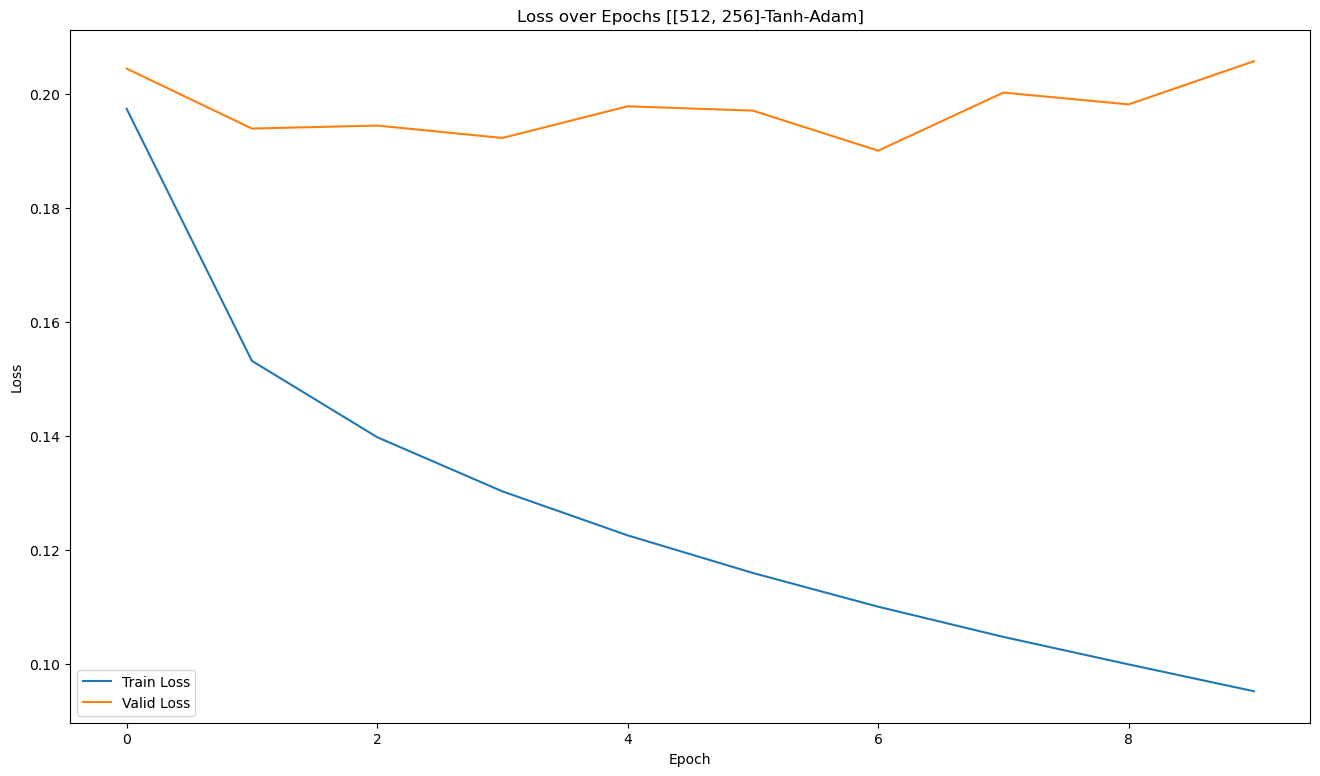

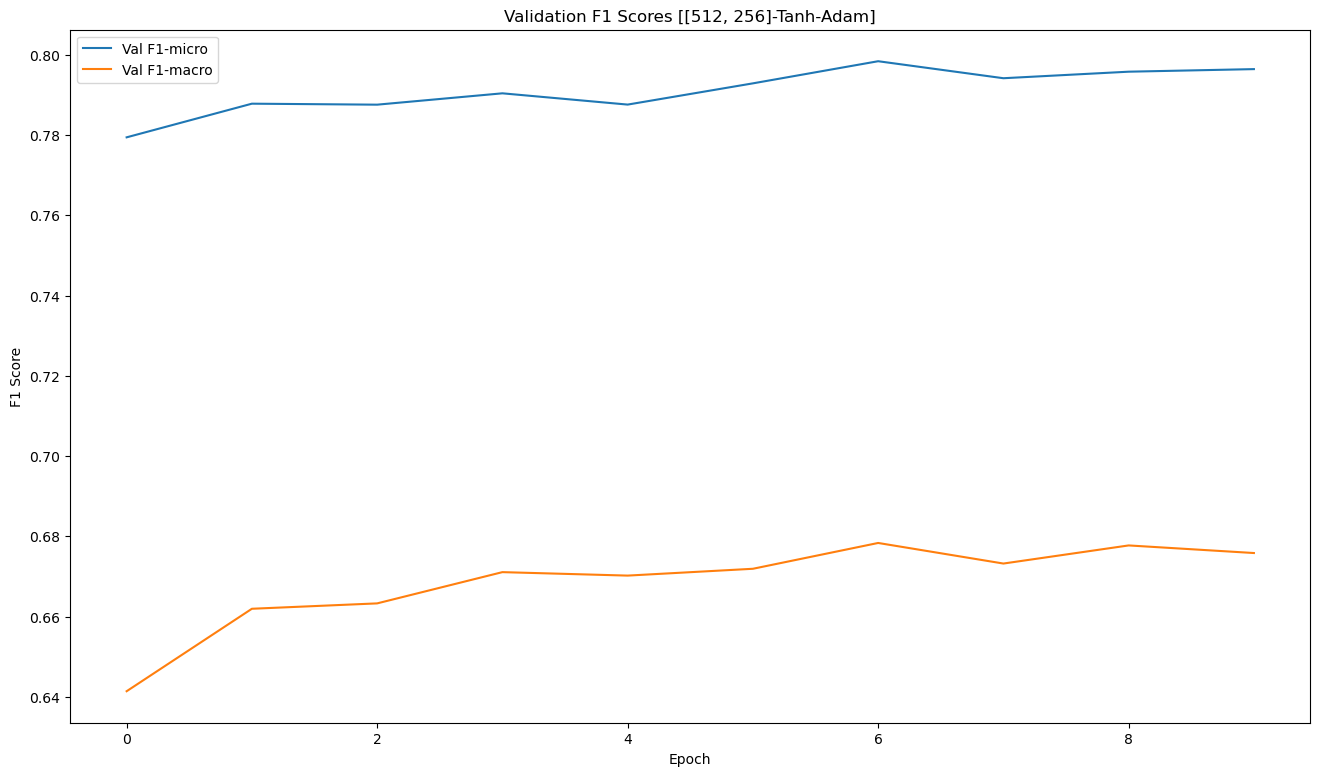

In [20]:
class Model(nn.Module):
    def __init__(self, embedding_dim, num_labels, hidden_sizes, activation_class):
        super().__init__()
        layers = []
        in_dim = embedding_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation_class())
            in_dim = h
        layers.append(nn.Linear(in_dim, num_labels))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


hidden_configs = [[], [512], [512, 256]]
activations = [nn.ReLU, nn.Tanh, nn.LeakyReLU]
opt_configs = [
    ("Adam", optim.Adam, dict(lr=1e-3, weight_decay=1e-5)),
    ("SGD", optim.SGD, dict(lr=1e-2, momentum=0.9)),
]

experiments = []
for hidden in hidden_configs:
    for act in activations:
        for opt_name, opt_class, opt_params in opt_configs:
            label = f"{hidden or 'none'}-{act.__name__}-{opt_name}"
            experiments.append({
                "hidden": hidden,
                "activation": act,
                "opt_name": opt_name,
                "opt_class": opt_class,
                "opt_params": opt_params,
                "label": label
            })

results = []
history = {}

for cfg in experiments:
    label = cfg["label"]

    model = Model(
        embedding_dim=X_train.shape[1],
        num_labels=y_train.shape[1],
        hidden_sizes=cfg["hidden"],
        activation_class=cfg["activation"]
    ).to(DEVICE)
    optimizer = cfg["opt_class"](model.parameters(), **cfg["opt_params"])
    criterion = nn.BCELoss()

    wrapper = TorchModelWrapper(model, DEVICE)

    train_losses, valid_losses = [], []
    valid_f1_micro, valid_f1_macro = [], []
    best_macro = -1.0
    best_model_state = None
    best_thresholds = None

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        tloss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tloss += loss.item()
        train_losses.append(tloss / len(train_loader))

        model.eval()
        vloss = 0.0
        vp, vt = [], []
        with torch.no_grad():
            for xb, yb in valid_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                preds = model(xb)
                vloss += criterion(preds, yb).item()
                vp.append(preds.cpu().numpy())
                vt.append(yb.cpu().numpy())
        valid_losses.append(vloss / len(valid_loader))

        vp = np.vstack(vp)
        vt = np.vstack(vt)

        thr = calculate_best_thresholds(wrapper, X_valid, y_valid)
        vpred = (vp >= thr)
        fmic = f1_score(vt, vpred, average='micro')
        fmac = f1_score(vt, vpred, average='macro')
        valid_f1_micro.append(fmic)
        valid_f1_macro.append(fmac)

        if fmac > best_macro:
            best_macro = fmac
            best_model_state = model.state_dict()
            best_thresholds = thr.copy()

        print(f"{cfg['label']} | Epoch {epoch} | "
              f"Time {time.time() - start_time:.4f}s | "
              f"Train Loss {train_losses[-1]:.4f} | Valid Loss {valid_losses[-1]:.4f} | "
              f"Val F1-micro {fmic:.4f} | Val F1-macro {fmac:.4f}")

    model.load_state_dict(best_model_state)
    model.eval()
    test_probs = np.column_stack([
        p[:, 1] for p in wrapper.predict_proba(X_test)
    ])
    test_pred = (test_probs >= best_thresholds)
    tfmic = f1_score(y_test, test_pred, average='micro')
    tfmac = f1_score(y_test, test_pred, average='macro')

    results.append({
        "config": cfg["label"],
        "test_micro": tfmic,
        "test_macro": tfmac,
        "best_epoch": np.argmax(valid_f1_macro) + 1
    })

    history[label] = {
        "train_loss": train_losses,
        "valid_loss": valid_losses,
        "val_f1_micro": valid_f1_micro,
        "val_f1_macro": valid_f1_macro,
    }

df = pd.DataFrame(results).sort_values("test_macro", ascending=False).reset_index(drop=True)
print(df)

best_cfg = df.loc[0, "config"]
hist = history[best_cfg]

plt.figure(figsize=(16, 9))
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["valid_loss"], label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Loss over Epochs [{best_cfg}]")

plt.figure(figsize=(16, 9))
plt.plot(hist["val_f1_micro"], label="Val F1-micro")
plt.plot(hist["val_f1_macro"], label="Val F1-macro")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.title(f"Validation F1 Scores [{best_cfg}]")

plt.show()

Вывод: лучше всего себя показала конфигурация ReLU с Adam Optimizer и одним скрытым слоем, хуже всего - бес слоев и с использованием SGD, так как сеорее всего модели просто не хватило параметров для обучения (модели без скрытых слоев в таблице находятся в среднем ниже остальных).

__Дополнительное задание (10 баллов):__ В экспериментах выше документ представляется в виде одного вектора. В задании предлагается разобраться с базовой теорией сверточных нейронных сетей самостоятельно и выполнить следующие пункты:

- заменить это представление на по-токенное (т.е. документ - матрица векторов, по одному на каждый токен)
- в качестве векторов попробовать использовать выходы BERT или обучить модель Word2vec/FastText
- предложить и реализовать способ организации процесса векторизации и обучения, чтобы избавиться от проблемы различной длины документов
- попробовать в качестве первого слоя в модели одномерный сверточный слой с Global Max Pooling или K-max Pooling поверх его выходов
- провести любые иные улучшения модели с использованием свёрточных слоёв, слоёв пулинга, линейных слоёв и нелинейных активаций
- задокументировать все эксперименты и попытаться получить результаты выше, чем у лучше модели из основной части задания

In [21]:
# your code here